# Imports

In [18]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import torch
import plotly_express as px

from huggingface_hub import notebook_login

from transformer_lens import HookedTransformer

# Model Loading
from sae_lens import SAE
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# Virtual Weight / Feature Statistics Functions
from sae_lens.analysis.feature_statistics import (
    get_all_stats_dfs,
    get_W_U_W_dec_stats_df,
)

# Enrichment Analysis Functions
from sae_lens.analysis.tsea import (
    get_enrichment_df,
    manhattan_plot_enrichment_scores,
    plot_top_k_feature_projections_by_token_and_category,
)
from sae_lens.analysis.tsea import (
    get_baby_name_sets,
    get_letter_gene_sets,
    generate_pos_sets,
    get_test_gene_sets,
    get_gene_set_from_regex,
)

In [20]:
# notebook_login()

# Load model and SAE

- Use Gemma 2 2b
- Start with 16k SAE, all layers (1-25)

In [21]:
model = HookedTransformer.from_pretrained("gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [22]:
# # this is an outdated way to load the SAE. We need to have feature spartisity loadable through the new interface to remove it.
# gpt2_small_sparse_autoencoders = {}
# gpt2_small_sae_sparsities = {}

# for layer in range(12):
#     sae, original_cfg_dict, sparsity = SAE.from_pretrained(
#         release="gemma-scope-2b-pt-res",
#         sae_id="blocks.0.hook_resid_post",
#         device="cpu",
#     )
#     gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] = sae
#     gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"] = sparsity

In [23]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_10/width_16k/average_l0_77",
    # sae_id="blocks.0.hook_resid_post",
    device="cuda",
)

# Load dataset

In [24]:

from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import json

dataset = load_dataset("codeparrot/apps", split="train")

Check dataset looks good

In [25]:
from collections import Counter
import json

# Print the dataset size
print(f"Dataset size: {len(dataset)}")

# Get a count of all difficulties
difficulty_counts = Counter(sample['difficulty'] for sample in dataset)

# Print the counts
print("\nDifficulties in sample:")
for difficulty, count in difficulty_counts.items():
    print(f"{difficulty}: {count}")

# Print the first sample
sample = next(iter(dataset))
sample["solutions"] = json.loads(sample["solutions"])
sample["input_output"] = json.loads(sample["input_output"])
print(sample)

Dataset size: 5000

Difficulties in sample:
interview: 2000
competition: 361
introductory: 2639
{'problem_id': 0, 'question': 'Polycarp has $n$ different binary words. A word called binary if it contains only characters \'0\' and \'1\'. For example, these words are binary: "0001", "11", "0" and "0011100".\n\nPolycarp wants to offer his set of $n$ binary words to play a game "words". In this game, players name words and each next word (starting from the second) must start with the last character of the previous word. The first word can be any. For example, these sequence of words can be named during the game: "0101", "1", "10", "00", "00001".\n\nWord reversal is the operation of reversing the order of the characters. For example, the word "0111" after the reversal becomes "1110", the word "11010" after the reversal becomes "01011".\n\nProbably, Polycarp has such a set of words that there is no way to put them in the order correspondent to the game rules. In this situation, he wants to r

# Want the following:

Run the model over each problem in the dataset. 

Should result in the following dataset, with one row per token in each problem:
- `problem_id`: unique identifier for each problem
- `token_pos`: token position in the problem
- `token_idx`: token index in the model
- `token_str`: string representation of the token

In [26]:
import pandas as pd
from sae_lens import ActivationsStore

def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

def create_batch_df(
    tokens,
    len_prefix=5, 
    len_suffix=3, 
    model=model,
):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    subsequence = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p == tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
            subsequence.append("".join(str_tokens[b][:p+1]))  # Add subsequence
    
    return pd.DataFrame(dict(
        problem_idx=prompt, 
        token_pos=pos, 
        token_str=list_flatten(str_tokens),
        token_lab=label,
    ))

In [43]:
import pandas as pd
import os


def generate_and_save_activations(
    dataset,
    model: HookedTransformer, 
    sae: SAE, 
    output_dir: str,
    batches_to_run: int = None,
    batch_size_prompts = 1,
    batch_size_tokens = 4096,
    sae_max_activations = 200, # only stores this many activation columns
    force = False # if True, will overwrite existing files
):
    """
    Iterates through the code dataset creating a dataframe of 
    feature activations at each token, saving batches to disk.
    """
    
    tokenized_dataset = tokenize_and_concatenate(
        dataset=dataset,
        tokenizer=model.tokenizer,
        column_name="solutions",
        max_length=sae.cfg.context_size, 
        add_bos_token=sae.cfg.prepend_bos
    )
    
    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        dataset=tokenized_dataset,  
        streaming=True,
        store_batch_size_prompts=batch_size_prompts,
        train_batch_size_tokens=batch_size_tokens,
        n_batches_in_buffer=32,
        device="cuda",
    )
    
    os.makedirs(output_dir, exist_ok=True)
    
    tokens = activation_store.get_batch_tokens()
    batch_idx = 0

    while tokens is not None:
        if batches_to_run and batch_idx >= batches_to_run:
            break
        
        output_file = os.path.join(output_dir, f'batch_{batch_idx}.parquet')
        print(f"[{output_dir}] Processing batch {batch_idx}")
        
        if not force and os.path.exists(output_file):
            print("Skipping batch, already exists")
        else:
            # Initialize activation dataset
            df = create_batch_df(tokens)
            
            # Run model with cache
            _, cache = model.run_with_cache(tokens, stop_at_layer=sae.cfg.hook_layer + 1, names_filter=[sae.cfg.hook_name])
            
            # Get SAE activations
            sae_in = cache[sae.cfg.hook_name]
            feature_acts = sae.encode(sae_in).squeeze()
            
            # Get the indices of the top k activations
            positive_acts = feature_acts * (feature_acts > 0)
            top_k_indices = torch.argsort(positive_acts, dim=-1, descending=True)[:, :sae_max_activations]
            
            # Create a mask for positive activations
            positive_mask = torch.gather(positive_acts, 1, top_k_indices) > 0
            
            # Apply the mask to top_k_indices
            masked_indices = torch.where(positive_mask, top_k_indices, torch.tensor(0, device=top_k_indices.device))
            
            # Convert to numpy and create DataFrame
            activation_dict = {f'activation_{i}': masked_indices[:, i].cpu().numpy() for i in range(sae_max_activations)}
            
            # Add all feature columns at once
            df = pd.concat([df, pd.DataFrame(activation_dict)], axis=1)
            
            # Save the dataframe to disk
            df.to_parquet(output_file)

            
        # Get a new batch of tokens
        batch_idx += 1 
        try:
            tokens = activation_store.get_batch_tokens(raise_at_epoch_end=True)
        except StopIteration:
            tokens = None

In [38]:
def load_activations(input_dir: str):
    """Loads activations from disk, combining them into a dataframe."""
    
    all_dfs = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.parquet'):
            file_path = os.path.join(input_dir, filename)
            df = pd.read_parquet(file_path)
            
            # Extract batch number from filename
            batch_num = int(filename.split('_')[1].split('.')[0])
            
            # Add batch column
            df['batch'] = batch_num
            
            # Create unique problem_id
            df['problem_id'] = df['batch'].astype(str) + '-' + df['problem_idx'].astype(str)
            
            all_dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    return combined_df

# Generate activation dataset for just the easy problems

In [44]:
easy_dataset = dataset.filter(lambda x: x['difficulty'] == 'introductory')
assert len(easy_dataset) > 0

test_dir = '/root/data/test'

generate_and_save_activations(
    dataset=easy_dataset,
    model=model,
    sae=sae,
    output_dir=test_dir,
    batches_to_run=10, # only run a few
    force=True
)

easy_df = load_activations(test_dir)

[/root/data/test] Processing batch 0


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(
/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 1


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 2


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 3


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 4


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 5


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 6


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 7


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 8


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


[/root/data/test] Processing batch 9


/root/.cache/pypoetry/virtualenvs/regular-explanations-2Z6nwjV7-py3.10/lib/python3.10/site-packages/sae_lens/training/activations_store.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(


In [45]:
easy_df.head()

,problem_idx,token_pos,token_str,token_lab,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,...,activation_192,activation_193,activation_194,activation_195,activation_196,activation_197,activation_198,activation_199,batch,problem_id
0,0,0,<bos>,0/0,4392,2843,3736,2575,5501,6655,...,5972,11254,12839,16048,3893,9764,16251,15472,0,0-0
1,0,1,<bos>,0/1,4392,2843,3736,2575,5501,6655,...,5972,11254,12839,16048,3893,9764,16251,15472,0,0-0
2,0,2,"[""",0/2,4392,3736,14372,381,1692,13213,...,0,0,0,0,0,0,0,0,0,0-0
3,0,3,from,0/3,14319,15603,14028,3986,1157,786,...,0,0,0,0,0,0,0,0,0,0-0
4,0,4,collections,0/4,14137,3986,6710,12238,14028,3279,...,0,0,0,0,0,0,0,0,0,0-0


# Sanity check initial run

Summary statistics for features fired per token:
count    10240.000000
mean        74.704785
std         25.332107
min         10.000000
25%         58.000000
50%         71.000000
75%         87.000000
max        200.000000
Name: features_fired, dtype: float64

Percentage of tokens with at least one feature firing: 100.00%


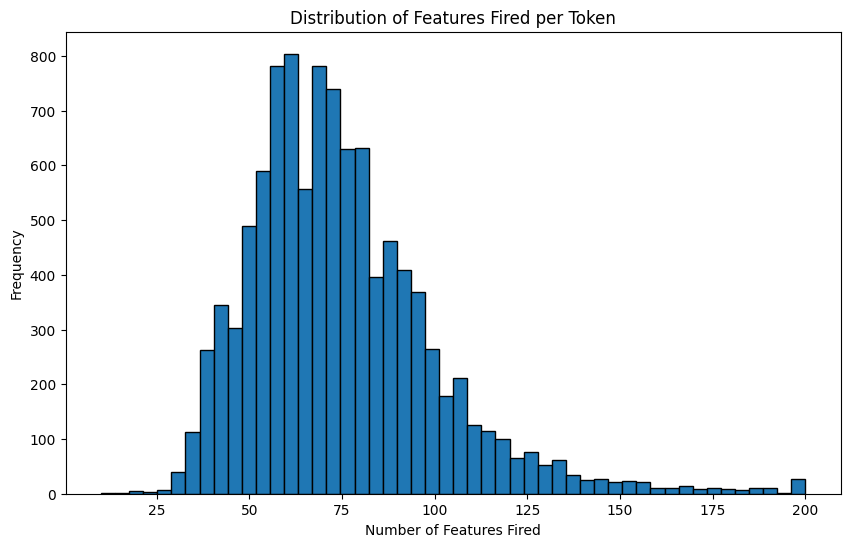

In [46]:
# Calculate the number of features that fired for each token
activation_columns = [col for col in easy_df.columns if col.startswith('activation_')]
easy_df['features_fired'] = (easy_df[activation_columns] > 0).sum(axis=1)

# Calculate summary statistics
summary_stats = easy_df['features_fired'].describe()

print("Summary statistics for features fired per token:")
print(summary_stats)

# Calculate the percentage of tokens with at least one feature firing
tokens_with_firing = (easy_df['features_fired'] > 0).sum()
total_tokens = len(easy_df)
percentage_with_firing = (tokens_with_firing / total_tokens) * 100

print(f"\nPercentage of tokens with at least one feature firing: {percentage_with_firing:.2f}%")

# Plot a histogram of features fired per token
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(easy_df['features_fired'], bins=50, edgecolor='black')
plt.title('Distribution of Features Fired per Token')
plt.xlabel('Number of Features Fired')
plt.ylabel('Frequency')
plt.show()

Why so many at 200?

In [48]:
high_firing_rows = easy_df[easy_df['features_fired'] > 195]
high_firing_rows = high_firing_rows.sort_values('features_fired', ascending=False)
print(len(high_firing_rows))
high_firing_rows[['problem_id', 'token_pos', 'token_str', 'features_fired']]

26


,problem_id,token_pos,token_str,features_fired
0,0-0,0,<bos>,200
1,0-0,1,<bos>,200
9216,9-0,0,<bos>,200
8192,8-0,0,<bos>,200
7699,7-0,531,bisect,200
7168,7-0,0,<bos>,200
6144,6-0,0,<bos>,200
5120,5-0,0,<bos>,200
4096,4-0,0,<bos>,200
3072,3-0,0,<bos>,200


Ok not a huge deal.

In [59]:
import os
import pandas as pd
import numpy as np

def reshape_and_save_activations(input_dir: str, output_dir: str, top_k: int = 200):
    """
    Loads parquet files from input_dir, reshapes them to store only top K activations,
    and saves the reshaped data to output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.parquet'):
            print(f"Processing {filename}")
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            
            # Load the dataframe
            df = pd.read_parquet(input_path)
            
            # Identify feature columns
            feature_columns = [col for col in df.columns if col.startswith('feature_')]
            
            # Create a DataFrame of feature activations
            feature_df = df[feature_columns]
            
            # Get the indices of the top k activations for each row
            top_k_indices = np.argsort(feature_df.values, axis=1)[:, ::-1][:, :top_k]
            
            # Get the values of the top k activations
            top_k_values = np.take_along_axis(feature_df.values, top_k_indices, axis=1)
            
            # Create a mask for positive activations
            positive_mask = top_k_values > 0
            
            # Apply the mask to top_k_indices (replace non-positive activations with 0)
            top_k_indices = np.where(positive_mask, top_k_indices, 0)
            
            # Create new columns for top K activations and their indices
            new_columns = pd.DataFrame(
                top_k_indices,
                columns=[f'activation_{i}' for i in range(top_k)],
                index=df.index
            )
            
            # Concatenate the new columns with the original dataframe
            df = pd.concat([df.drop(columns=feature_columns), new_columns], axis=1)
            
            # Save the reshaped dataframe
            df.to_parquet(output_path)
            
    print("Reshaping complete!")

# Usage
input_directory = '/root/data/easy'
output_directory = '/root/data/introductory'
reshape_and_save_activations(input_directory, output_directory)

Processing batch_0.parquet
Processing batch_1.parquet
Processing batch_2.parquet
Processing batch_3.parquet
Processing batch_4.parquet
Processing batch_5.parquet
Processing batch_6.parquet
Processing batch_7.parquet
Processing batch_8.parquet
Processing batch_9.parquet
Processing batch_10.parquet
Processing batch_11.parquet
Processing batch_12.parquet
Processing batch_13.parquet
Processing batch_14.parquet
Processing batch_15.parquet
Processing batch_16.parquet
Processing batch_17.parquet
Processing batch_18.parquet
Processing batch_19.parquet
Processing batch_20.parquet
Processing batch_21.parquet
Processing batch_22.parquet
Processing batch_23.parquet
Processing batch_24.parquet
Processing batch_25.parquet
Processing batch_26.parquet
Processing batch_27.parquet
Processing batch_28.parquet
Processing batch_29.parquet
Processing batch_30.parquet
Processing batch_31.parquet
Processing batch_32.parquet
Processing batch_33.parquet
Processing batch_34.parquet
Processing batch_35.parquet
Pr

In [62]:

easy_df = load_activations(easy_problem_dir)

In [63]:
len(easy_df['problem_id'].unique())

1597

Summary statistics for features fired per token:
count    1.635328e+06
mean     7.128430e+01
std      2.067621e+01
min      7.000000e+00
25%      5.800000e+01
50%      6.900000e+01
75%      8.100000e+01
max      2.000000e+02
Name: features_fired, dtype: float64

Percentage of tokens with at least one feature firing: 100.00%


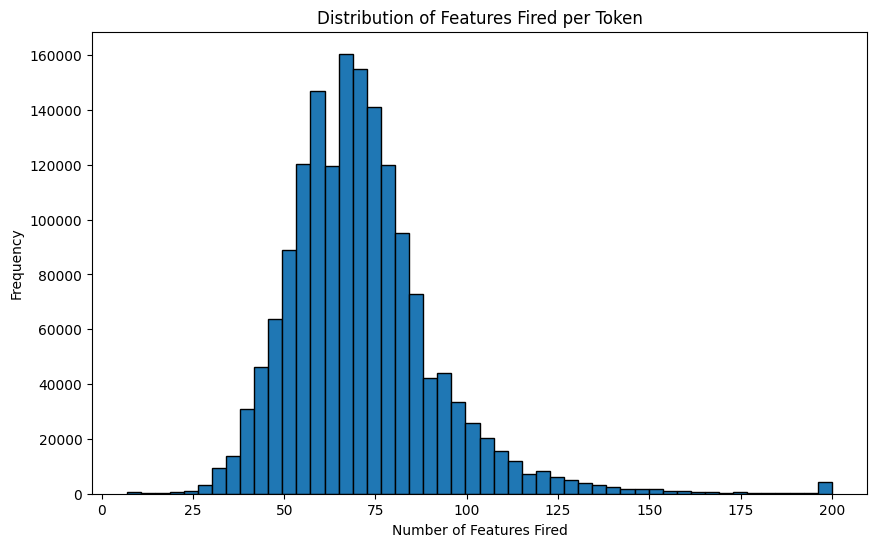

In [64]:
# Calculate the number of features that fired for each token
activation_columns = [col for col in easy_df.columns if col.startswith('activation_')]
easy_df['features_fired'] = (easy_df[activation_columns] > 0).sum(axis=1)

# Calculate summary statistics
summary_stats = easy_df['features_fired'].describe()

print("Summary statistics for features fired per token:")
print(summary_stats)

# Calculate the percentage of tokens with at least one feature firing
tokens_with_firing = (easy_df['features_fired'] > 0).sum()
total_tokens = len(easy_df)
percentage_with_firing = (tokens_with_firing / total_tokens) * 100

print(f"\nPercentage of tokens with at least one feature firing: {percentage_with_firing:.2f}%")

# Plot a histogram of features fired per token
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(easy_df['features_fired'], bins=50, edgecolor='black')
plt.title('Distribution of Features Fired per Token')
plt.xlabel('Number of Features Fired')
plt.ylabel('Frequency')
plt.show()

In [51]:
easy_df.head()

,problem_idx,token_pos,token_str,token_lab,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,...,activation_192,activation_193,activation_194,activation_195,activation_196,activation_197,activation_198,activation_199,batch,problem_id
0,0,0,<bos>,0/0,8191,5536,2723,5527,12767,12768,...,8919,8917,13038,2522,13041,13042,13043,2520,0,0-0
1,0,1,<bos>,0/1,8191,5536,2723,5527,12767,12768,...,8919,8917,13038,2522,13041,13042,13043,2520,0,0-0
2,0,2,"[""",0/2,7437,4888,7260,8869,13632,7495,...,5606,5605,5604,5603,5602,5601,5600,5599,0,0-0
3,0,3,from,0/3,10670,11356,14120,15386,15261,13597,...,5555,5554,5553,5552,5551,5550,5549,5548,0,0-0
4,0,4,collections,0/4,12238,10806,15165,7226,14137,12681,...,5415,5414,5578,5412,5579,5580,5575,5406,0,0-0


In [ ]:
easy_problem_dir = '/root/data/introductory'

# generate_and_save_activations(
#     dataset=easy_dataset,
#     model=model,
#     sae=sae,
#     output_dir=easy_problem_dir,
# )

easy_df = load_activations(easy_problem_dir)

In [ ]:
from datasets import Dataset
from huggingface_hub import HfApi, create_repo

def save_df_to_huggingface(df, repo_name, token, private=True):
    """
    Save a DataFrame to a Hugging Face dataset.

    Args:
    df (pd.DataFrame): The DataFrame to save.
    repo_name (str): The name of the repository to create/use on Hugging Face.
    token (str): Your Hugging Face API token.
    private (bool): Whether the repository should be private. Defaults to True.

    Returns:
    str: The URL of the created dataset on Hugging Face.
    """
    # Convert DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)

    # Create or get the repository
    api = HfApi()
    try:
        repo_url = api.create_repo(
            repo_id=repo_name,
            token=token,
            private=private,
            repo_type="dataset",
            exist_ok=True
        )
    except Exception as e:
        print(f"Error creating repository: {e}")
        return None

    # Push the dataset to the Hugging Face Hub
    dataset.push_to_hub(repo_name, token=token)

    print(f"Dataset successfully uploaded to {repo_url}")
    return repo_url

# Usage example:
# repo_name = "your-username/your-dataset-name"
# token = "your_huggingface_token"
# url = save_df_to_huggingface(easy_df, repo_name, token)

# Make explanation verifier

Want the following:

Given a chunk of the activation dataset and some set of explanations, generate a dataset with one row per (token, explanation) pair, and with columns:
- `problem_id`: unique identifier for each problem
- `token_pos`: token position in the problem
- `token_idx`: token index in the model
- `token_str`: string representation of the token
- `explanation_feature`: the feature of the explanation
- `explanation_tag`: the explanation tag
- `feature_did_fire`: whether the feature fired or not
- `explanation_did_fire`: whether the explanation fired or not

In [ ]:
from dataclasses import dataclass
import re
from typing import Optional
      
@dataclass
class RegexExplanation:
    feature: int
    tag: str
    rank: int # how common this syntax feature was in the dataset
    position_regex: str                  # checks the current token
    sequence_regex: Optional[str] = None # checks the entire sequence (up to and including current token)
    
    def check(self, df: pd.DataFrame) -> pd.DataFrame:
        """Evaluates the quality of the explanation over a prompt-slice of the dataframe."""
            
        assert len(problem_df['problem_id'].unique()) == 1, "More than one problem_id passed into check"
            
        # filter the dataframe for the given problem_id
        problem_df = df.copy()
        
        # sort by token position to ensure correct order
        problem_df = problem_df.sort_values('token_pos')
        
        # initialize columns for explanation evaluation
        problem_df['explanation_did_fire'] = False
        problem_df['feature_did_fire'] = problem_df[f'feature_{self.feature}']
        
        # evaluate the explanation for each token
        for i, row in problem_df.iterrows():
            last_token_regex_matches = re.search(self.position_regex, row['token_str']) is not None
            if self.sequence_regex:
                subsequence = ''.join(problem_df[problem_df['token_pos'] <= row['token_pos']]['token_str'])
                sequence_regex_matches = re.search(self.sequence_regex, subsequence) is not None
                problem_df.at[i, 'explanation_did_fire'] = last_token_regex_matches and sequence_regex_matches
            else:
                problem_df.at[i, 'explanation_did_fire'] = last_token_regex_matches
        
        # clean up resulting dataframe
        feature_columns = [col for col in df.columns if col.startswith('feature_')]
        problem_df = problem_df.drop(columns=feature_columns)
        problem_df['explanation_feature'] = self.feature
        problem_df['explanation_tag'] = self.tag
        
        return problem_df

# Try to find some obvious syntax features

- Operators like `+`, `-`, `*`, `/`, `^`, `=`, `==`, `!=`, `>`, `<`, `>=`, `<=`, `and`, `or`, `not`, `in`, `is`, `not in`, `is not`
- Punctuation like `(`, `)`, `[`, `]`, `{`, `}`, `,`, `:`, `;`, `.`
- Keywords like `if`, `else`, `elif`, `for`, `while`, `def`, `return`, `break`, `continue`, `pass`, `import`, `from`, `as`, `with`, `try`, `except`, `finally`, `raise`, `assert`, `global`, `nonlocal`, `del`, `lambda`, `yield`, `class`, `is`, `in`, `not`, `and`, `or`, `True`, `False`, `None`
- Comments...

(thanks copilot...)

Simplest example: special characters, e.g. `[`. Find all tokens that contain one, and then cluster their features. Let's include multicharacter substrings that are likely to just live inside of one token as well.

In [ ]:
substring_types = {
    "Brackets and Delimiters": ["[", "]", "(", ")", "{", "}", "'", '"'],
    "Punctuation and Separators": [":", ",", ".", ";", " ", "\n", "\t", "\r"],
    "Operators": [
        "+", "-", "*", "/", "=", "<", ">", "&", "|", "!", 
        "^", "~", "@", "%"
    ],
    "Keywords": [
        "if", "else", "elif", "for", "while", "def", "in", 
        "or", "and", "not", "return", 
        "True", "False", "None", "break",
    ],
    "Built-ins": [
      "len", "sum", "max", "min", "abs", "round", "zip", "any", "all", "print", "input", "range"
    ],
}

In [ ]:
from typing import Iterable, Tuple


def find_top_activations_for_token_substring(df: pd.DataFrame, substring, k=5):
    activation_counts = {}
    for _, row in df.iterrows():
        if substring in row['token_str']:
            for col in df.columns:
                if col.startswith('activation_'):
                    activation = row[col]
                    if activation > 0:  # Only count positive activations
                        activation_counts[activation] = activation_counts.get(activation, 0) + 1
    sorted_activations = sorted(activation_counts.items(), key=lambda x: x[1], reverse=True)
    return dict(sorted_activations[:k])

def print_top_activations_for_token_substring(df: pd.DataFrame, substring, k=5):
    top_activations = find_top_activations_for_token_substring(df, substring, k)
    print(f"{substring}")
    for activation, count in top_activations.items():
        print(f"\tActivation {activation}: {count} occurrences")
        
def substrings() -> Iterable[Tuple[str, str]]:
    for tag, substrings in substring_types.items():
        for substring in substrings:
            yield substring, tag
 

In [ ]:
for substring, tag in substrings()[:20:5]:
    print_top_activations_for_token_substring(easy_df, substring)

# Plot initial results

1. Take the 5 most common activations for each of these syntax features and turn them into Explanations. 
2. Run each Explanation over the full distribution
3. Plot the precision, recall, and f1 of each Explanation

Break #3 out by:
- Syntax feature
- Syntax feature tag/bucket
- Order of "how common the activation was for that syntax feature"

Want dataset:
- `explanation_id`: unique index for each explanation
- `syntax_feature`: the syntax feature
- `syntax_feature_tag`: the syntax feature tag
- `feature_rank`: how common this feature was for this syntax feature
- `problem_id`: unique identifier for each problem
- `token_pos`: token position in the problem
- `feature_did_fire`: whether the feature fired or not
- `explanation_did_fire`: whether the explanation fired or not

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def create_explanations():
    explanations = []
    for substring, tag in substrings():
        top_activations = find_top_activations_for_token_substring(easy_df, substring, k=5)
        for rank, (feature, _) in enumerate(top_activations.items(), 1):
            explanations.append(RegexExplanation(
                feature=feature,
                tag=tag,
                rank=rank,
                position_regex=f".*{substring}.*",
                sequence_regex=None
            ))
    return explanations

def evaluate_explanations(df, explanations: list[RegexExplanation]):
    results = []
    for explanation in explanations:
        evaluated_df = explanation.check(df)
        for _, row in evaluated_df.iterrows():
            results.append({
                'explanation_id': f"{explanation.tag}_{explanation.feature}_{explanation.rank}",
                'syntax_feature': explanation.position_regex.replace('.*', ''),
                'syntax_feature_tag': explanation.tag,
                'feature_rank': explanation.rank,
                'problem_id': row['problem_id'],
                'token_pos': row['token_pos'],
                'feature_did_fire': row['feature_did_fire'],
                'explanation_did_fire': row['explanation_did_fire']
            })
    return pd.DataFrame(results)

def calculate_metrics(group):
    return pd.Series({
        'precision': precision_score(group['feature_did_fire'], group['explanation_did_fire']),
        'recall': recall_score(group['feature_did_fire'], group['explanation_did_fire']),
        'f1': f1_score(group['feature_did_fire'], group['explanation_did_fire'])
    })

# Create and evaluate explanations
explanations = create_explanations()
results_df = evaluate_explanations(easy_df, explanations)

# Calculate metrics
metrics_df = results_df.groupby(['explanation_id', 'syntax_feature', 'syntax_feature_tag', 'feature_rank']).apply(calculate_metrics).reset_index()

# Plotting functions
def plot_metrics_by_feature(metrics_df, metric):
    plt.figure(figsize=(12, 6))
    for feature in metrics_df['syntax_feature'].unique():
        feature_df = metrics_df[metrics_df['syntax_feature'] == feature]
        plt.plot(feature_df['feature_rank'], feature_df[metric], label=feature)
    plt.xlabel('Feature Rank')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} by Syntax Feature and Rank')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_metrics_by_tag(metrics_df, metric):
    plt.figure(figsize=(12, 6))
    for tag in metrics_df['syntax_feature_tag'].unique():
        tag_df = metrics_df[metrics_df['syntax_feature_tag'] == tag]
        plt.plot(tag_df['feature_rank'], tag_df[metric], label=tag)
    plt.xlabel('Feature Rank')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} by Syntax Feature Tag and Rank')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot results
for metric in ['precision', 'recall', 'f1']:
    plot_metrics_by_feature(metrics_df, metric)
    plot_metrics_by_tag(metrics_df, metric)